## Objectives
KITTI dataset contains various sequences from different categories such as optical flow, visual odometry, raw dataset.
In the visual odometry dataset, the ground truth pose has slight misalignment in z-axis in comparison to the GPS data.
In this notebook, we identify the angle misalignment and use it for angle compensation.

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import Image

sys.path.append('/app/src')

from src.internal.extended_common import (
    CoordinateFrame,
    Pose, State,
    ExtendedConfig,
    KITTI_SEQUENCE_TO_DATE,
    KITTI_SEQUENCE_TO_DRIVE
)
from src.internal.dataset import OXTS_GPSDataReader
from src.common.datatypes import State, Pose
from src.utils.geometric_transformer import GeometryTransformer, TransformationField
from src.utils.geometric_transformer.base_geometric_transformer import BaseGeometryTransformer

warnings.filterwarnings("ignore")

In [19]:
def get_compensated_angle(sequence: str):
    ground_truth_root_path = '/app/data/KITTI/ground_truth'
    gt = pd.read_csv(os.path.join(ground_truth_root_path, f'{sequence}.txt'), sep=' ', header=None).values.reshape(-1, 3, 4)


    drive = KITTI_SEQUENCE_TO_DRIVE.get(sequence, '2011_09_26_drive_0005_sync')
    date = KITTI_SEQUENCE_TO_DATE.get(sequence, '2011_09_26')

    gps_data_reader = OXTS_GPSDataReader(
        root_path='/app/data/KITTI/',
        date=date,
        drive=drive
    )
    config = ExtendedConfig(config_filepath="/app/configs/kitti_config.yaml")
    transformer = GeometryTransformer(config.hardware)
    state = State(p=np.zeros((3, 1)), v=np.zeros((3, 1)), q=np.array([1, 0, 0, 0]).reshape(-1, 1), b_w=np.zeros((3, 1)), b_a=np.zeros((3, 1)))

    gps_data = iter(gps_data_reader)
    gps_inertial = []
    for item in gps_data:
        z = np.array([item.lon, item.lat, item.alt])
        _gps = transformer.transform(
            fields=TransformationField(
                state=state,
                value=z,
                coord_from=CoordinateFrame.GPS,
                coord_to=CoordinateFrame.INERTIAL,
            )
        )
        gps_inertial.append(_gps.flatten())

    gps_inertial = np.array(gps_inertial)
    gps_inertial.shape

    gt_inertial = []
    for pos in gt:
        _gt = transformer.transform(
            fields=TransformationField(
                state=state,
                value=pos,
                coord_from=CoordinateFrame.STEREO_LEFT,
                coord_to=CoordinateFrame.INERTIAL,
            )
        )
        gt_inertial.append(_gt[:3, 3].flatten())

    gt_inertial = np.array(gt_inertial)
    gps_xy = gps_inertial[:, :2]
    gt_xy = gt_inertial[:, :2]

    angle = BaseGeometryTransformer.yaw_misalignment_from_two_points(gps_xy[0], gps_xy[1], gt_xy[0], gt_xy[1])
    return gt_inertial, gps_inertial, angle

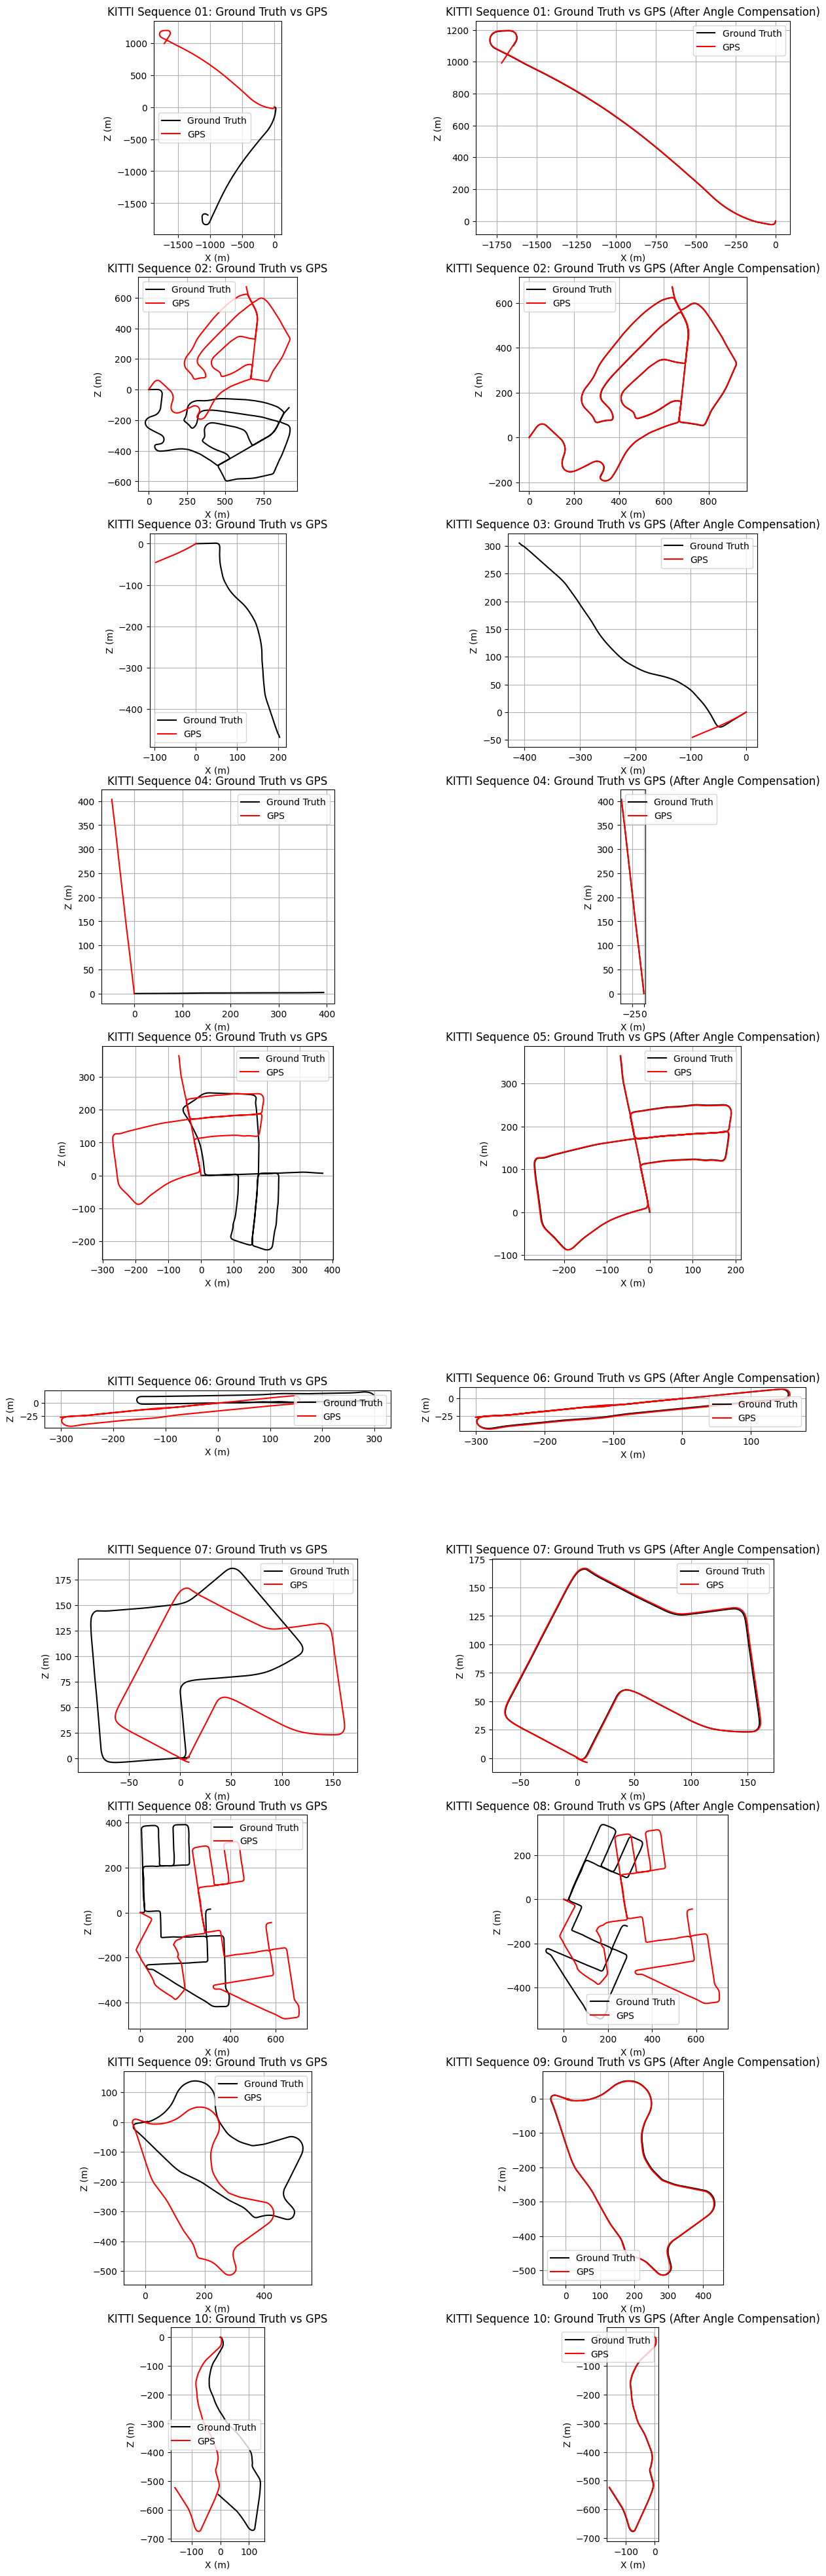

In [20]:
angle_compensation = {}
fig, axs = plt.subplots(10, 2, figsize=(15, 50))
for i, sequence in enumerate(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']):
    gt_inertial, gps_inertial, angle = get_compensated_angle(sequence)
    angle_compensation[sequence] = angle
    ax = axs[i, 0]
    px, py, pz = gt_inertial.T
    ax.plot(px, py, label='Ground Truth', color='black')
    gx, gy, gz = gps_inertial.T
    ax.plot(gx, gy, label='GPS', color='red')
    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(f'KITTI Sequence {sequence}: Ground Truth vs GPS')
    ax.grid()

    px, py, pz = BaseGeometryTransformer.Rz(angle) @ gt_inertial.T
    ax = axs[i, 1]
    ax.plot(px, py, label='Ground Truth', color='black')
    gx, gy, gz = gps_inertial.T
    ax.plot(gx, gy, label='GPS', color='red')
    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(f'KITTI Sequence {sequence}: Ground Truth vs GPS (After Angle Compensation)')
    ax.grid()

In [21]:
angle_compensation

{'01': 1.6094591872298871,
 '02': -0.9372291460128102,
 '03': 2.619759341608741,
 '04': -1.6808379130084723,
 '05': -1.7388183857263326,
 '06': 3.0622027349914167,
 '07': 0.5641313911083438,
 '08': 0.44960066680059524,
 '09': 0.4801864400707715,
 '10': 0.2800126998468973}

In [13]:
gt_inertial, gps_inertial, angle = get_compensated_angle("08")

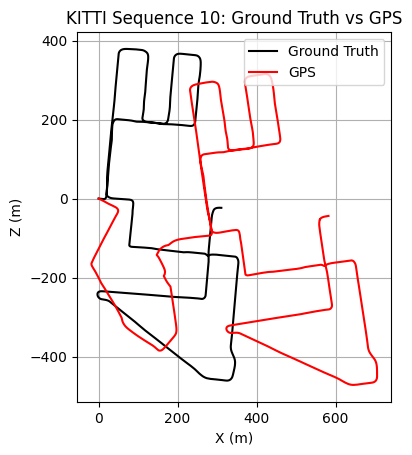

In [18]:
px, py, pz = BaseGeometryTransformer.Rz(angle) @ gt_inertial.T
plt.plot(px, py, label='Ground Truth', color='black')
plt.plot(gps_inertial[:, 0], gps_inertial[:, 1], label='GPS', color='red')
plt.legend()
plt.gca().set_aspect('equal')
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title(f'KITTI Sequence {sequence}: Ground Truth vs GPS')
plt.grid()